<hr style="border:2px solid #0281c9"> </hr>

<img align="left" alt="ESO Logo" src="http://archive.eso.org/i/esologo.png">  

<div align="center">
  <h1 style="color: #0281c9; font-weight: bold;">ESO Science Archive</h1> 
  <h2 style="color: #0281c9; font-weight: bold;">Jupyter Notebooks</h2>
</div>

<hr style="border:2px solid #0281c9"> </hr>

# **Reduced Data: Query for by Source Name or Position**

This notebook demonstrates how to use the `astroquery.eso` module to search for and download raw and reduced HAWK-I near-infrared observations from the ESO archive, specifically targeting Sgr A*, the supermassive black hole at the center of the Milky Way. It guides users through querying both the main ESO archive table and instrument-specific tables, filtering results based on observation parameters, and retrieving raw, unprocessed data for further calibration and analysis, enabling direct access to ESO’s extensive collection of observational datasets.

<hr style="border:2px solid #0281c9"> </hr>

# **Importing and basic usage of astroquery.eso**

In [1]:
import astroquery # import astroquery
print(f"astroquery version: {astroquery.__version__}") # check the version of astroquery

astroquery version: 0.4.11.dev10245


In [2]:
from astroquery.eso import Eso # import the ESO module from astroquery

In [3]:
eso = Eso() # create an instance of the ESO class 

# **Performing a Small Cone Search Around Sgr A***

To perform a small cone search of **10 arcseconds** around the source **Sgr A**, we first need to resolve the source name to obtain its **Right Ascension (RA)** and **Declination (Dec)** coordinates. This can be done using an online name resolver such as the ``SkyCoord.from_name()`` method from astropy.coordinates, which allows us to resolve object names into precise RA/Dec coordinates using online astronomical databases. This gives (ICRS): 

```python
ra = 266.41681663
dec = -29.00782497
```

In coordinate values of degrees in the ICRS (International Celestial Reference System) frame.

In [4]:
from astropy.coordinates import SkyCoord # import the SkyCoord class from the astropy.coordinates module
import astropy.units as u # import the astropy.units module

In [5]:
target = "Sgr A*" # set the target to Sgr A*
coords = SkyCoord.from_name(target) # create a SkyCoord object from the name of the source 
radius = 3 *u.arcmin # set the radius of the search to 3 arcminutes

print(f"Coordinates of Sgr A*: {coords}") # print the coordinates of Sgr A*

Coordinates of Sgr A*: <SkyCoord (ICRS): (ra, dec) in deg
    (266.41681663, -29.00782497)>


In [6]:
eso.maxrec = 1000    # For this example we limit the number of records to 1000

## **Reduced data cone search**

The `query_surveys()` method allows you to search ESO's reduced (science-grade) data products, such as imaging, spectra, and data cubes, across a wide range of public survey collections. 

Before starting a query, we can inspect the available queryable columns using the `help=True` keyword in the `query_surveys()` method. This is a useful first step to understand what metadata is available and how to structure your query (if additional constraints are needed). The output includes `column name`, `data type`, `unit`, and, where applicable, `xtype` information to indicate more specific column content. For example, a column with datatype char may represent a timestamp or a sky region, which is reflected in the xtype field (e.g., timestamp or adql:REGION).

In [7]:
eso.query_surveys(help=True)

INFO: 
Columns present in the table ivoa.ObsCore:
    column_name     datatype    xtype     unit 
------------------- -------- ----------- ------
           abmaglim   double                mag
     access_estsize     long              kbyte
      access_format     char                   
         access_url     char                   
      bib_reference     char                   
        calib_level      int                   
dataproduct_subtype     char                   
   dataproduct_type     char                   
              dp_id     char                   
             em_max   double                  m
             em_min   double                  m
       em_res_power   double                   
             em_xel     long                   
      facility_name     char                   
             filter     char                   
            gal_lat   double                deg
            gal_lon   double                deg
    instrument_name     char          

Now we know what columns we're going to retrieve in from query, we can use the cone search functionality available through `query_surveys()` by passing `cone_ra`, `cone_dec`, and `cone_radius` arguments...

In [8]:
table_reduced = eso.query_surveys(column_filters={"instrument_name": "HAWKI"},
                                cone_ra=coords.ra.value, 
                                cone_dec=coords.dec.value, 
                                cone_radius=radius.to("deg").value) # query the ESO archive for HAWKI data

table_reduced["target_name", "s_ra", "s_dec", "proposal_id", "instrument_name", "dp_id"][:3] # print the first 3 rows of the table

target_name,s_ra,s_dec,proposal_id,instrument_name,dp_id
,deg,deg,,,
object,float64,float64,object,object,object
FAST-SGRA-1,266.427,-28.973507,195.B-0283(A),HAWKI,ADP.2021-04-30T12:05:58.663
FAST-SGRA-2,266.34776,-29.007882,195.B-0283(A),HAWKI,ADP.2021-04-30T12:05:58.749
FAST-SGRA-2,266.38631,-28.952327,195.B-0283(A),HAWKI,ADP.2021-04-30T12:05:58.753


At this point it may be useful to know some information about the columns in the table. We can print the column names and their descriptions as follows:

In [9]:
print("Column Descriptions:\n" + "-" * 25)
for colname in table_reduced.colnames:
    desc = table_reduced[colname].info.description
    desc_str = desc if desc is not None else "[no description]"
    print(f"{colname:>25}: {desc_str}")

Column Descriptions:
-------------------------
              target_name: The target name as assigned by the Principal Investigator; ref. Ref. OBJECT keyword in ESO SDP standard. For spectroscopic public surveys, the value shall be set to the survey source identifier, which shall be unique within the survey
                     s_ra: Equatorial coordinate: Right Ascension (FK5/J2000); Image/tile/cube centre, barycentre of image arrays in MEF format ; spectroscopic target position; centre of the survey field in case of catalogues. Ref. RA keyword in ESO SDP standard.
                    s_dec: Equatorial coordinate: Declination (FK5/J2000); Image/tile/cube centre, barycentre of image arrays in MEF format ; spectroscopic target position; centre of the survey field in case of catalogues. Ref. DEC keyword in ESO SDP standard.
                    dp_id: ESO-specific field not present in the standard ObsCore. The original ESO identifier of the main science file. ObsCore uses obs_publisher_di

### 📊 **Visualizing Metadata Distributions**

The cell below creates a multi-panel figure showing the distribution of key metadata fields returned from the ESO archive query. For each column:

- **Numeric fields** (e.g., `abmaglim`, `t_exptime`) are shown as histograms.
- **Categorical fields** (e.g., `proposal_id`, `filter`, `dataproduct_type`, `p3orig`) are shown as bar charts, with counts of each unique value.

This is useful to:
- Get an overview of your query results,
- Identify dominant filters, programs, or dataproduct types,
- Examine the range and spread of exposure times or limiting magnitudes.

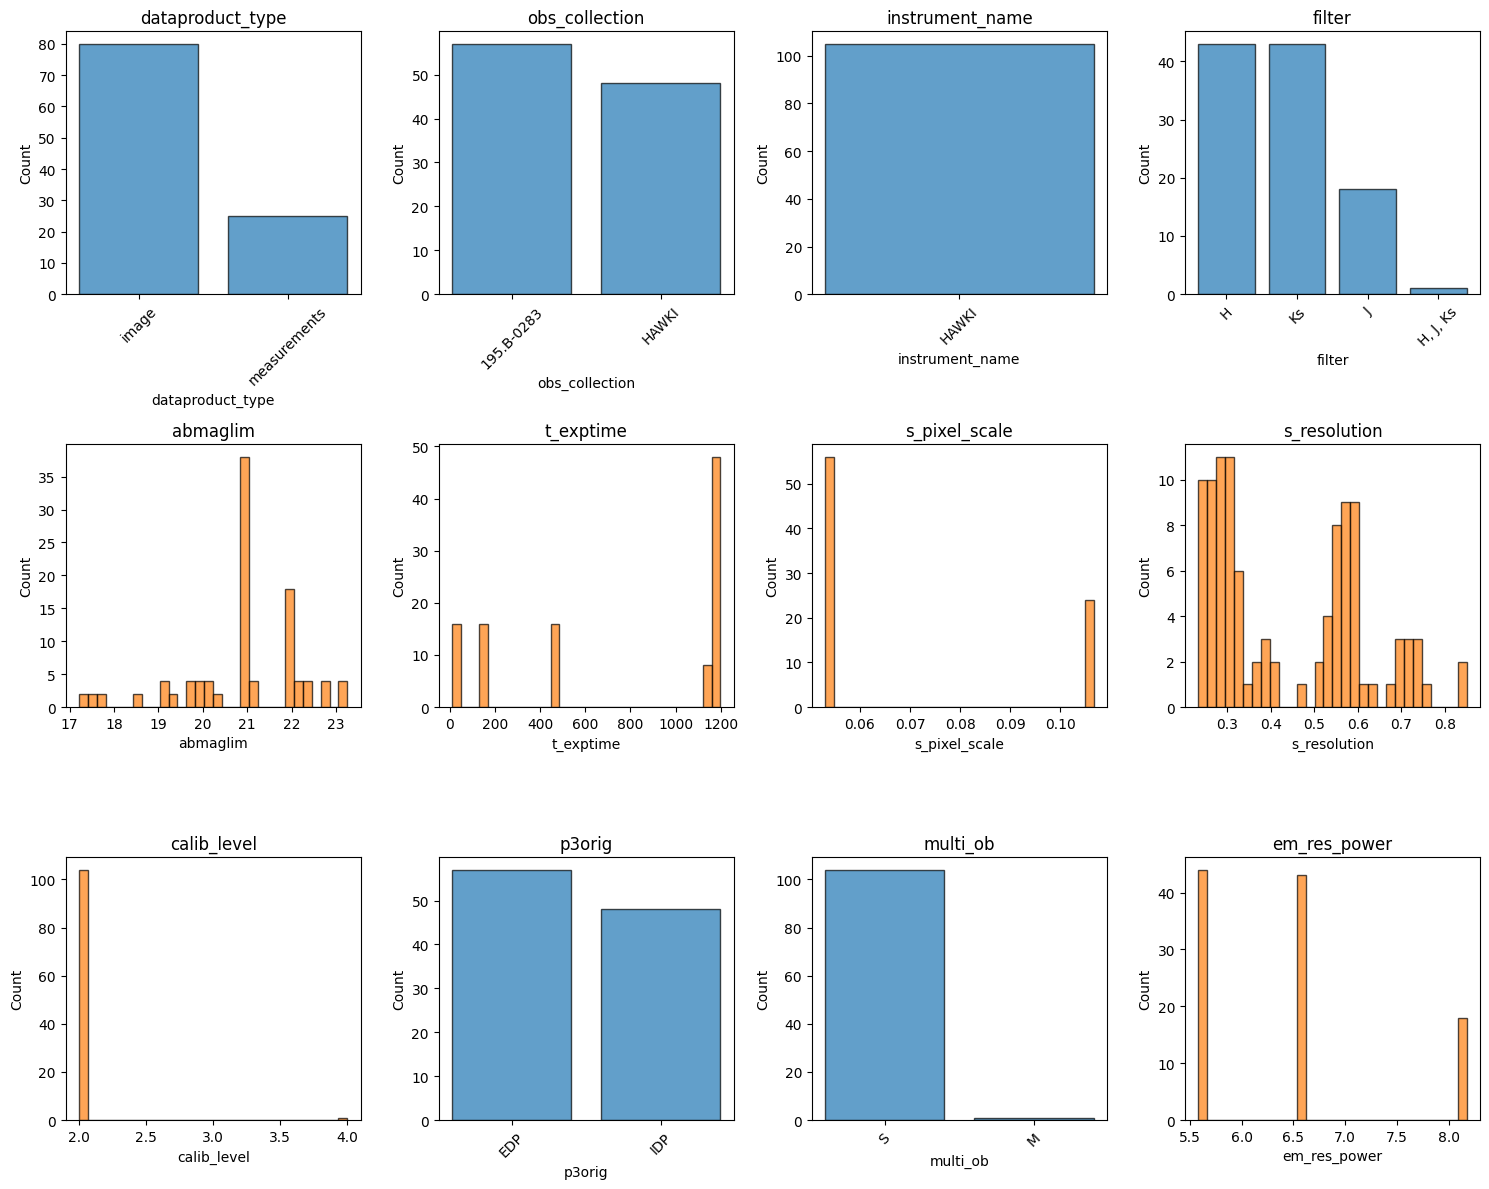

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Define columns to plot
columns = [
    "dataproduct_type", "obs_collection", "instrument_name", "filter", "abmaglim",
      "t_exptime", "s_pixel_scale", "s_resolution", "calib_level", "p3orig", 
    "multi_ob", "em_res_power"
]

# Prepare plot grid
n = len(columns)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4 * nrows))
axes = axes.flatten()

# Loop over each column
for ax, col in zip(axes, columns):
    data = table_reduced[col]
    
    # Remove masked or NaN values
    if np.ma.is_masked(data):
        data = data[~data.mask]
    data = data[~np.isnan(data)] if data.dtype.kind in 'f' else data  # remove NaNs from floats

    # Check if numeric or categorical
    if data.dtype.kind in 'biufc':  # numeric
        ax.hist(data, bins=30, color='C1', edgecolor='black', alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
    else:  # categorical
        counts = Counter(data)
        labels, values = zip(*counts.most_common())
        ax.bar(labels, values, color='C0', edgecolor='black', alpha=0.7)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        ax.tick_params(axis='x', rotation=45)

    ax.set_title(col)

# Hide any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()

# **Downloading datasets from the archive**

The returned table has an ``dp_id`` column. It can be used to retrieve the datasets with ``retrieve_data()``.

The file names, returned in ``data_files``, points to the decompressed datasets (without the .Z extension) that have been locally downloaded. 

The default location (in the ``astropy`` cache) of the decompressed datasets can be adjusted by providing a destination keyword in the call to ``retrieve_data()``. By default, if a requested dataset is already found, it is not downloaded again from the archive. To force the retrieval of data that are present in the destination directory, use ``continuation=True`` in the call to ``retrieve_data()``.

In [11]:
# data_files = eso.retrieve_data(table_reduced["dp_id"][0]) # download the first data product
# data_files = eso.retrieve_data(table_reduced['dp_id'][0], continuation=True) # force the download of all files even if present in the destination directory
# data_files = eso.retrieve_data(table_reduced['dp_id'][0], destination='./') # specify the destination directory for the download

<hr style="border:2px solid #0281c9"> </hr>